In [2]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import re
import PIL
from PIL import Image
import locale
from datetime import datetime
locale.setlocale(locale.LC_ALL, '')
import csv

In [3]:
import requests
import json

In [4]:
df = pd.read_csv("fires_since_2005_landcover.csv")
df.columns

Index(['Unnamed: 0', 'COUNTY_FULL_CODE', 'X', 'FIRE_YEAR', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE',
       'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY',
       'FIPS_CODE', 'DATE', 'END_DATE', 'STATE_FIPS', 'COUNTY_CODE', 'County',
       'State', 'Landcover'],
      dtype='object')

## Cleaning the data after mapping additional attributes
- Includes creating a new variable *FIRE_DUR*, which measures the duration of the fire

In [5]:
df["COUNTY_FULL_CODE"] = df["COUNTY_FULL_CODE"].apply(str)

In [6]:
df.dtypes

Unnamed: 0            int64
COUNTY_FULL_CODE     object
X                     int64
FIRE_YEAR             int64
DISCOVERY_DATE      float64
DISCOVERY_DOY         int64
DISCOVERY_TIME      float64
STAT_CAUSE_CODE       int64
STAT_CAUSE_DESCR     object
CONT_DATE           float64
CONT_DOY            float64
CONT_TIME           float64
FIRE_SIZE           float64
FIRE_SIZE_CLASS      object
LATITUDE            float64
LONGITUDE           float64
STATE                object
COUNTY               object
FIPS_CODE             int64
DATE                 object
END_DATE             object
STATE_FIPS            int64
COUNTY_CODE           int64
County               object
State                object
Landcover             int64
dtype: object

In [7]:
def convert_county(fips):
    if len(fips) < 5:
        num_zeros = 5-len(fips)
        return '0'*num_zeros+fips
    else:
        return fips
df["COUNTY_FULL_CODE"] = df["COUNTY_FULL_CODE"].apply(convert_county)

In [8]:
df["DATE"] = df["DATE"].apply(lambda x: datetime.strptime(x[:10],"%Y-%m-%d"))
df["END_DATE"] = df["END_DATE"].apply(lambda x: datetime.strptime(x[:10],"%Y-%m-%d"))
df.dtypes

Unnamed: 0                   int64
COUNTY_FULL_CODE            object
X                            int64
FIRE_YEAR                    int64
DISCOVERY_DATE             float64
DISCOVERY_DOY                int64
DISCOVERY_TIME             float64
STAT_CAUSE_CODE              int64
STAT_CAUSE_DESCR            object
CONT_DATE                  float64
CONT_DOY                   float64
CONT_TIME                  float64
FIRE_SIZE                  float64
FIRE_SIZE_CLASS             object
LATITUDE                   float64
LONGITUDE                  float64
STATE                       object
COUNTY                      object
FIPS_CODE                    int64
DATE                datetime64[ns]
END_DATE            datetime64[ns]
STATE_FIPS                   int64
COUNTY_CODE                  int64
County                      object
State                       object
Landcover                    int64
dtype: object

In [9]:
df["CONT_TIME"] = df["CONT_TIME"].fillna(0)
df["CONT_TIME"] = df["CONT_TIME"].apply(str)
df["CONT_TIME"]=df["CONT_TIME"].apply(lambda x: x[:-2])
df.at[df["CONT_TIME"] == '0', "CONT_TIME"] = '0000'

def convert_time(x):
    if len(x) < 4:
        return '0'*(4-len(x))+x
    else:
        return x

df["CONT_TIME"] = df["CONT_TIME"].apply(convert_time)

df["DISCOVERY_TIME"] = df["DISCOVERY_TIME"].fillna(0) 
df["DISCOVERY_TIME"] = df["DISCOVERY_TIME"].apply(lambda x: str(x)[:-2])

In [10]:
df.at[df["DISCOVERY_TIME"] == '0', "DISCOVERY_TIME"] = '0000'
df["DISCOVERY_TIME"] = df["DISCOVERY_TIME"].apply(convert_time)

In [12]:
df[["DATE", "DISCOVERY_TIME","END_DATE", "CONT_TIME"]].head()

DATE DISCOVERY_TIME   END_DATE CONT_TIME
0 2011-05-31           1710 2011-05-31      1753
1 2015-08-24           1100 2015-08-25      0900
2 2015-06-24           1520 2015-07-21      1000
3 2006-06-28           1826 2006-06-28      2130
4 2015-08-27           1156 2015-08-27      1800

In [13]:
df["DISCOVERY_TIME"] = df["DISCOVERY_TIME"].apply(lambda x: datetime.strptime(x, "%H%M"))
df["CONT_TIME"] = df["CONT_TIME"].apply(lambda x: datetime.strptime(x, "%H%M"))

In [14]:
df["FIRE_DUR"] = df.apply(lambda x: (x["CONT_TIME"] - x["DISCOVERY_TIME"]).seconds, axis=1)
df["FIRE_DUR"] = df["FIRE_DUR"].apply(lambda x: x/3600)
df[["FIRE_DUR"]].head()

FIRE_DUR
0   0.716667
1  22.000000
2  18.666667
3   3.066667
4   6.066667

## Plotting the distribution of *FIRE_DUR* 

In [18]:
fig = go.Figure(go.Histogram(x=df["FIRE_DUR"]),layout=dict(title_text="Histogram of Duration of Fire (Hours)"))
fig.show()

In [40]:
# Let's filter out outliers
ub = np.percentile(df["FIRE_DUR"], 95)
lb = np.percentile(df["FIRE_DUR"], 5)
keep = df.loc[(df["FIRE_DUR"] < ub) & (df["FIRE_DUR"] > lb)]
fig=go.Figure(go.Histogram(x=keep["FIRE_DUR"]), layout=dict(title_text="Histogram of Duration of Fires without Outliers (Hours)"))
fig.show()

In [41]:
cols_keep = ["COUNTY_FULL_CODE", "FIRE_YEAR", "STAT_CAUSE_DESCR", "FIRE_SIZE", "FIRE_SIZE_CLASS", "LATITUDE", "LONGITUDE", "Landcover", "FIRE_DUR"]

In [42]:
keep = keep[cols_keep]

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [44]:
cols = list(keep.columns)
x_pred = cols[:-1]
y_pred = cols[-1]

In [45]:
print("Predictor variable:", x_pred)
print("Response variable:", y_pred)

Predictor variable: ['COUNTY_FULL_CODE', 'FIRE_YEAR', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'Landcover']
Response variable: FIRE_DUR


In [46]:
categorical_var = ['COUNTY_FULL_CODE', 'STAT_CAUSE_DESCR', "FIRE_SIZE_CLASS", "Landcover"]
keep_encoded = pd.get_dummies(keep, columns=categorical_var)

In [47]:
keep_label = keep.copy()
le = LabelEncoder()
for cat_col in categorical_var:
    keep_label[cat_col]= le.fit_transform(keep[cat_col])


In [53]:
cols = list(keep_encoded.columns)
cols.remove('FIRE_DUR')

In [50]:
x_col_label = list(keep_label.columns)
x_col_label.remove("FIRE_DUR")
y_col_label = 'FIRE_DUR'

In [51]:
X_label = keep_label[x_col_label]
y_label = keep_label[y_col_label]

In [54]:
y_col = 'FIRE_DUR'
x_col = cols

X = keep_encoded[x_col]
y = keep_encoded['FIRE_DUR']

## Splitting the dataset into training and testing sets

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [55]:
X2_train, X2_test, y1_train, y1_test = train_test_split(X_label, y_label, test_size=0.3, random_state=0)

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [61]:
regressor = RandomForestRegressor(n_estimators=20, random_state=2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
((y_pred - y_test)**2).mean()

19.44629085301913

In [69]:
print("R^2:",regressor.score(X_train,y_train))
regressor.feature_importances_*100

R^2: 0.8743834953321994


array([1.44006713e+01, 1.02641308e+01, 2.65717700e+01, 2.92021100e+01,
       8.40691605e-02, 3.29817717e-02, 1.22909395e-01, 4.24922060e-02,
       1.00108117e-01, 3.05492291e-02, 1.32374012e-01, 1.16727347e-01,
       1.77389497e-01, 1.21080643e-01, 5.35320505e-02, 1.73909620e-01,
       3.56282304e-02, 9.68374783e-02, 1.35051328e-01, 3.02721106e-02,
       5.91550760e-02, 1.12830043e-01, 1.02308283e-01, 9.90393628e-02,
       4.66927078e-02, 4.31265734e-02, 1.94027976e-02, 1.25324881e-01,
       1.47495026e-01, 3.09859476e-02, 5.83142080e-02, 1.87415567e-02,
       1.03960200e-01, 1.97224928e-01, 1.47984555e-01, 5.76124820e-02,
       1.01580382e-01, 1.67671992e-01, 1.08185267e-01, 4.38956743e-02,
       9.21364395e-02, 7.40256465e-02, 8.42303968e-02, 7.05984920e-02,
       7.73093386e-02, 4.48769194e-02, 2.82881765e-02, 8.03032113e-02,
       1.07007617e-01, 1.07177830e-01, 1.88192397e-01, 2.21194089e-01,
       1.81376979e-01, 2.16058370e-02, 1.22166543e-01, 3.98478312e-02,
      

In [90]:
X_test.columns

Index(['FIRE_YEAR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE',
       'COUNTY_FULL_CODE_04001', 'COUNTY_FULL_CODE_04003',
       'COUNTY_FULL_CODE_04005', 'COUNTY_FULL_CODE_04007',
       'COUNTY_FULL_CODE_04009', 'COUNTY_FULL_CODE_04011',
       ...
       'Landcover_489', 'Landcover_556', 'Landcover_579', 'Landcover_583',
       'Landcover_584', 'squared_err', 'FIRE_DUR', 'err', 'percent_err',
       'pred'],
      dtype='object', length=148)

In [58]:
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),
                          n_estimators=100, random_state=1)

regr_2.fit(X2_train, y1_train)

# Predict
y_2 = regr_2.predict(X2_test)

In [59]:
((y_2 - y1_test)**2).mean()

27.54146371348315

In [134]:
((y_pred - y_test)**2).mean()

18.996513569729107

In [70]:
squared_err = (y_pred - y_test)**2
squared_err = squared_err.to_frame()

In [77]:
X_test["squared_err"] = squared_err["FIRE_DUR"]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

In [79]:
len(X_test[X_test["squared_err"] < 1])/len(X_test)

0.3499175897887999

In [80]:
accurate_ = X_test[X_test["squared_err"] < 2]
county_cols = [x for x in accurate_.columns if 'COUNTY_FULL_CODE' in x]
county_accurate_x = accurate_[county_cols]

In [95]:
accurate_.head()

FIRE_YEAR  FIRE_SIZE   LATITUDE   LONGITUDE  COUNTY_FULL_CODE_04001  \
52894       2015       0.10  34.305833 -118.395556                       0   
16443       2014       0.10  33.542100 -112.066500                       0   
39350       2008      10.00  36.908889 -119.243611                       0   
95855       2013       0.39  40.582850 -122.448483                       0   
51344       2012       0.10  34.453889 -117.990278                       0   

       COUNTY_FULL_CODE_04003  COUNTY_FULL_CODE_04005  COUNTY_FULL_CODE_04007  \
52894                       0                       0                       0   
16443                       0                       0                       0   
39350                       0                       0                       0   
95855                       0                       0                       0   
51344                       0                       0                       0   

       COUNTY_FULL_CODE_04009  COUNTY_FULL_CODE_04011  ...  Landcover_489  \
52894                       0                       0  ...              0   
16443                       0                       0  ...              0   
39350                       0                       0  ...              0   
95855                       0                       0  ...              0   
51344                       0                       0  ...              0   

       Landcover_556  Landcover_579  Landcover_583  Landcover_584  \
52894              0              0              0              0   
16443              0              0              0              0   
39350              1              0              0              0   
95855              0              0              0              0   
51344              0              0              0              0   

       squared_err  FIRE_DUR       err  percent_err      pred  
52894     0.053284  0.366667  0.230833     0.629545  0.597500  
16443     0.008556  0.150000  0.092500     0.616667  0.242500  
39350     0.777336  2.733333  0.881667     0.322561  3.615000  
95855     0.308951  0.250000  0.555833     2.223333  0.805833  
51344     0.000803  0.533333  0.028333     0.053125  0.505000  

[5 rows x 148 columns]

In [82]:
county_accurate_x = county_accurate_x.sum().to_frame()
county_accurate_x.columns = ["counts"]

In [83]:
full_cols = X_test.columns
county_cols = [x for x in full_cols if 'COUNTY_FULL_CODE' in x]
counts_by_county = X_test[county_cols].sum()
counts_by_county = counts_by_county.to_frame()
counts_by_county.columns = ["nums"]

In [84]:
county_accurate_x["full_nums"] = counts_by_county["nums"]
county_accurate_x["accuracy"]=county_accurate_x["counts"]/county_accurate_x["full_nums"]
county_accurate_x.sort_values(by="accuracy", ascending=False)

counts  full_nums  accuracy
COUNTY_FULL_CODE_06023     579        936  0.618590
COUNTY_FULL_CODE_06047     344        557  0.617594
COUNTY_FULL_CODE_06065    1063       1731  0.614096
COUNTY_FULL_CODE_06007     261        453  0.576159
COUNTY_FULL_CODE_06025      16         28  0.571429
COUNTY_FULL_CODE_04021     175        314  0.557325
COUNTY_FULL_CODE_06037     524        956  0.548117
COUNTY_FULL_CODE_06045     203        372  0.545699
COUNTY_FULL_CODE_04013     612       1142  0.535902
COUNTY_FULL_CODE_06017     321        610  0.526230
COUNTY_FULL_CODE_06039     225        429  0.524476
COUNTY_FULL_CODE_06021      22         43  0.511628
COUNTY_FULL_CODE_06089     285        573  0.497382
COUNTY_FULL_CODE_06005      84        176  0.477273
COUNTY_FULL_CODE_06103     144        307  0.469055
COUNTY_FULL_CODE_06057     125        273  0.457875
COUNTY_FULL_CODE_06115      95        208  0.456731
COUNTY_FULL_CODE_06073     335        739  0.453315
COUNTY_FULL_CODE_06087      83        184  0.451087
COUNTY_FULL_CODE_32003     167        372  0.448925
COUNTY_FULL_CODE_06001      57        127  0.448819
COUNTY_FULL_CODE_06107     200        447  0.447427
COUNTY_FULL_CODE_06061     224        505  0.443564
COUNTY_FULL_CODE_06055      62        142  0.436620
COUNTY_FULL_CODE_04001     164        377  0.435013
COUNTY_FULL_CODE_06053      79        182  0.434066
COUNTY_FULL_CODE_06071     337        778  0.433162
COUNTY_FULL_CODE_06015      69        160  0.431250
COUNTY_FULL_CODE_06009     116        270  0.429630
COUNTY_FULL_CODE_04009     232        558  0.415771
...                        ...        ...       ...
COUNTY_FULL_CODE_32007      94        293  0.320819
COUNTY_FULL_CODE_32005      23         72  0.319444
COUNTY_FULL_CODE_06091      38        119  0.319328
COUNTY_FULL_CODE_06111      50        158  0.316456
COUNTY_FULL_CODE_06031      20         64  0.312500
COUNTY_FULL_CODE_06003      21         68  0.308824
COUNTY_FULL_CODE_04023      35        114  0.307018
COUNTY_FULL_CODE_06013      47        155  0.303226
COUNTY_FULL_CODE_32031      52        174  0.298851
COUNTY_FULL_CODE_06095      17         58  0.293103
COUNTY_FULL_CODE_32023       9         31  0.290323
COUNTY_FULL_CODE_04027      38        132  0.287879
COUNTY_FULL_CODE_06083      30        105  0.285714
COUNTY_FULL_CODE_04011      47        166  0.283133
COUNTY_FULL_CODE_04015     145        515  0.281553
COUNTY_FULL_CODE_06081      21         75  0.280000
COUNTY_FULL_CODE_06093     174        626  0.277955
COUNTY_FULL_CODE_06075       6         22  0.272727
COUNTY_FULL_CODE_32015      12         47  0.255319
COUNTY_FULL_CODE_06029      93        365  0.254795
COUNTY_FULL_CODE_06067      50        197  0.253807
COUNTY_FULL_CODE_04012      23         92  0.250000
COUNTY_FULL_CODE_32019       9         36  0.250000
COUNTY_FULL_CODE_06049      73        309  0.236246
COUNTY_FULL_CODE_32029       5         24  0.208333
COUNTY_FULL_CODE_06011       8         41  0.195122
COUNTY_FULL_CODE_06101       6         34  0.176471
COUNTY_FULL_CODE_06041       6         50  0.120000
COUNTY_FULL_CODE_32001       1         13  0.076923
COUNTY_FULL_CODE_32009       0          0       NaN

[88 rows x 3 columns]

In [85]:
retrieve_well_performing = county_accurate_x.sort_values(by="accuracy", ascending=False)
well_performing = retrieve_well_performing.head(12).reset_index()
well_performing_fips = well_performing["index"].apply(lambda x: x[-5:])
well_performing_fips = list(well_performing_fips)

In [86]:
well_performing_fips

['06023',
 '06047',
 '06065',
 '06007',
 '06025',
 '04021',
 '06037',
 '06045',
 '04013',
 '06017',
 '06039',
 '06021']

In [87]:
total_counts_landcover = keep.groupby("Landcover").count()[["COUNTY_FULL_CODE"]]

Our predictions worked well for areas which has a Landcover with codes 474, 472, 477 and 302
- The Landcover codes stand for deserts and forests

In [89]:
good_performance = keep.loc[keep["COUNTY_FULL_CODE"].isin(well_performing_fips)]
good_performance_landcover = good_performance.groupby("Landcover").count()[["COUNTY_FULL_CODE"]]
good_performance_landcover["total"] = total_counts_landcover[["COUNTY_FULL_CODE"]]
good_performance_landcover["percentage"] = good_performance_landcover["COUNTY_FULL_CODE"]/good_performance_landcover["total"]
good_performance_landcover

COUNTY_FULL_CODE  total  percentage
Landcover                                     
42                     1967   5468    0.359729
165                    4180   5340    0.782772
302                    3175   5599    0.567066
472                    5526  11876    0.465308
474                    4969   6749    0.736257
477                     119    119    1.000000
556                    5029  12005    0.418909

In [92]:
fig=go.Figure(go.Histogram(x=X_test["squared_err"]),layout=dict(title_text="Histogram of Squared Errors"))
fig.show()

In [94]:
fig=go.Figure(go.Histogram(x=X_test["squared_err"].apply(np.sqrt)),layout=dict(title_text="Histogram of Absolute Errors"))
fig.show()

In [101]:
pd.Series(y_pred)

0         4.257500
1         8.044167
2         0.597500
3         0.242500
4         5.030833
5         3.615000
6         0.805833
7         0.505000
8         2.147500
9         1.408333
10        8.672500
11        0.825833
12        7.808333
13        8.347500
14        3.608333
15        2.614167
16        4.428333
17        9.370833
18        7.347500
19        4.937500
20        0.567500
21        0.333333
22        2.833333
23        0.258333
24        3.006667
25       11.313333
26       12.300000
27        4.679167
28        7.004167
29        9.880000
           ...    
26059     3.215000
26060     5.349167
26061     1.616667
26062     3.457500
26063     0.405833
26064     3.155833
26065     4.330000
26066     5.501667
26067     2.410833
26068     1.696667
26069     1.100833
26070     1.658333
26071    12.498333
26072     4.974167
26073    10.480000
26074     1.247500
26075     6.200000
26076     9.840833
26077     5.535000
26078     8.286667
26079     2.195000
26080    11.

In [116]:
y_test1 = y_test.reset_index()["FIRE_DUR"]
y_pred1 = pd.Series(y_pred)

In [117]:
def classify_bins(x):
    if x <1.5:
        return 'short'
    elif x < 5:
        return 'moderate'
    else:
        return 'long'

In [118]:
y_test1 = y_test1.to_frame()
y_test1.columns=["actual"]
y_pred1= y_pred1.to_frame()
y_pred1.columns=["pred"]

In [119]:
y_test1["binned"] = y_test1["actual"].apply(classify_bins)
y_pred1["binned"] = y_pred1["pred"].apply(classify_bins)

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

### Plotting the confusion matrix

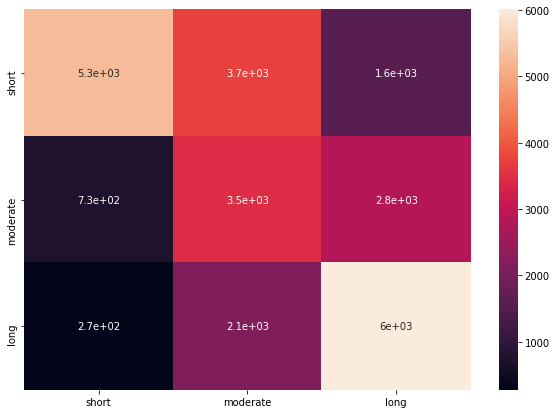

In [123]:
conf_matrix = confusion_matrix(y_test1["binned"], y_pred1["binned"], labels=['short', "moderate", "long"])

labels = ['short', "moderate", "long"]
df_cm = pd.DataFrame(conf_matrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)